In [1]:
import os
import sys
from matplotlib import pyplot as plt
from PIL import Image
from skimage.io import imread, imshow, imsave
from skimage import img_as_float, img_as_ubyte
from numpy import roll, clip, round, dstack
import numpy as np
from skimage import color
import math
from matplotlib.pyplot import hist

In [2]:
# линейное растяжение по каналам

In [3]:
def entropy2(one, two):
    sum_one = 0
    sum_two = 0
    size = len(one)*len(one[0])
    for i in range(len(one)):
        for j in range(len(one[0])):
            #pi = math.fabs(one[i,j]-two[i,j])/size
            p1 = math.fabs(one[i,j]/size)
            p2 = math.fabs(two[i,j]/size)
            #res += pi* math.log2(pi)
            sum_one += p1* math.log2(p1)
            sum_two += p2* math.log2(p2)
    print(sum_one, sum_two)
    return math.fabs(sum_one - sum_two)
def entropy4(one,two):
    res1 = 0 
    res2 = 0
    size = one.shape[0]*one.shape[1]
    values1, bin_edges1, patches1 = hist(one.ravel(), bins=range(257))
    values2, bin_edges2, patches2 = hist(two.ravel(), bins=range(257))
    for i in range(len(values1)):
        p1 = math.fabs(values1[i]/size)
        p2 = math.fabs(values2[i]/size)
        #print(p1, p2)
        if (p1>0):
            res1 += p1* math.log2(p1)
        if (p2>0):
            res2 += p2* math.log2(p2)
    print(res1, res2)
    return math.fabs(res1-res2)
def msi(one, two):
    e = 0
    for i in range(len(one)):
        for j in range(len(one[0])):
            e += round(one[i][j] - two[i][j])**2
    e = (e / (one.shape[0]*one.shape[1] - 1))**(1/2)
    return e

In [4]:
def splice(img1, img2):
    y = min(img1.shape[1],img2.shape[1])
    x = img1.shape[0]/2+img2.shape[0]/2
    x1 = img1.shape[0]/2
    new_img = np.zeros((x, y))
    new_img = img1
    new_img[x/2:x, 0:y] = img2[img2.shape[0]/2:img2.shape[0], 0:y]
    return new_img
def splice2(img1, img2):
    y = min(img1.shape[1],img2.shape[1])
    x = img1.shape[0]/2+img2.shape[0]/2
    x1 = img1.shape[0]/2
    new_img = np.zeros((x, y))
    new_img = np.copy(img1)
    new_img[0:x, y/2:y] = np.copy(img2[0:x, y/2:y])
    return new_img

In [5]:
def yuvToRGB(y, u, v):
    rd = y[:,:] + 1.402*(v[:,:] - 128)
    gr = y[:,:] - 0.34414*(u[:,:] - 128) - 0.71414*(v[:,:] - 128)
    bl = y[:,:] + 1.772*(u[:,:] - 128)
    return rd, gr, bl
def make_u(rgb):
    return (-0.1687*rgb[:,:,0] - 0.3313*rgb[:,:,1] + 0.5*rgb[:,:,2] + 128)
def make_v(rgb):
    return (0.5*rgb[:,:,0] - 0.4187*rgb[:,:,1] - 0.0813*rgb[:,:,2] + 128)
def make_y(rgb):
    return (0.299*rgb[:,:,0] + 0.587*rgb[:,:,1] + 0.114*rgb[:,:,2])
def rgbToYUV(rgb):
    u = -0.1687*rgb[:,:,0] - 0.3313*rgb[:,:,1] + 0.5*rgb[:,:,2] + 128
    v = 0.5*rgb[:,:,0] - 0.4187*rgb[:,:,1] - 0.0813*rgb[:,:,2] + 128
    y = 0.299*rgb[:,:,0] + 0.587*rgb[:,:,1] + 0.114*rgb[:,:,2]
    return y, u, v

In [6]:
# отбрасываем самые темные пиксели
# отбрасываем самые светлые пиксели

def listOfPix(llist):
    new_list = []
    for i in range(len(llist)):
        if llist[i]!=0:
            new_list.append(i)
    return new_list
'''
def find_Min_Max(img, lght_list, dark_list):
    new_max = min(lght_list)
    new_min = max(dark_list)
    for i in range(img.shape[0]):
        for i in range(img.shape[1]):
    return new_max, new_min
'''
def findMin(llist, lght_list):
    for i in range(0, len(llist)):
        if ((llist[i] not in lght_list) and llist[i]!=0):
            return llist[i]
def findMax(llist, dark_list):
    for i in range (len(llist)-1,-1,-1,):
        #print(llist[i])
        if ((llist[i] not in dark_list) and llist[i]!=0):
            return llist[i]
def takeParts(m, nim, xam):
    part1 = np.zeros((m.shape[0], m.shape[1]))
    part2 = np.zeros((m.shape[0], m.shape[1]))
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if m[i,j]<nim or m[i,j]>xam:
                part1[i,j] = m[i,j]
            else:
                part2[i,j] = m[i,j]
    return part1, part2
def mergeParts(part1, part2, nim, xam):
    res = np.zeros((part1.shape[0], part1.shape[1]))
    for i in range(part1.shape[0]):
        for j in range(part1.shape[1]):
            if part1[i,j]>0:
                if part2[i,j]>nim or part2[i,j]<xam:
                    res[i,j] = part1[i,j]
            else:
                res[i,j] = part2[i,j]
    return res

In [7]:
def ChannalLinear1(m, percent):
    values, bin_edges, patches = hist(m.ravel(), bins=range(256))
    YnotZeroValuesList = listOfPix(values)
    k = int(len(YnotZeroValuesList)*percent/100)
    new_min = YnotZeroValuesList[k]
    new_max = YnotZeroValuesList[len(YnotZeroValuesList)-k-1]
    # for vituality dropped elements
    #lght_list = YnotZeroValuesList[0:k]
    #dark_list = YnotZeroValuesList[len(YnotZeroValuesList)-k:len(YnotZeroValuesList)]
    #print(lght_list, dark_list)    
    m = (m - new_min) * (255 / (new_max - new_min))
    return m
def Linear1(im, percent):   
    r = ChannalLinear1(im[:,:,0], percent)
    g = ChannalLinear1(im[:,:,1], percent)
    b = ChannalLinear1(im[:,:,2], percent)
    return clip(dstack((r, g, b)), 0, 255).astype('uint8')

def ChannalLinear2(m, percent):
    values, bin_edges, patches = hist(m.ravel(), bins=range(256))
    y_s = m.copy().reshape(-1)
    y_s.sort()
    k = int(len(y_s)*percent/100)
    new_min = y_s[k]
    new_max = y_s[len(y_s)-k-1]    
    m = (m - new_min) * (255 / (new_max - new_min))
    return m
def Linear2(im, percent):   
    r = ChannalLinear2(im[:,:,0], percent)
    g = ChannalLinear2(im[:,:,1], percent)
    b = ChannalLinear2(im[:,:,2], percent)
    return clip(dstack((r, g, b)), 0, 255).astype('uint8')

In [8]:
def LinearForgotten(im, percent):
    values, bin_edges, patches = hist(im.ravel(), bins=range(256))
    YnotZeroValuesList = listOfPix(values)
    k = int(len(YnotZeroValuesList)*percent/100)
    new_min = YnotZeroValuesList[k]
    new_max = YnotZeroValuesList[len(YnotZeroValuesList)-k-1]

    # for vituality dropped elements
    #lght_list = YnotZeroValuesList[0:k]
    #dark_list = YnotZeroValuesList[len(YnotZeroValuesList)-k:len(YnotZeroValuesList)]
    #print(lght_list, dark_list)
    
    r = np.clip(np.uint8((im[:,:,0] - new_min) *
                         (255 / (new_max - new_min))), 0, 255)
    g = np.clip(np.uint8((im[:,:,1] - new_min) *
                         (255 / (new_max - new_min))), 0, 255)
    b = np.clip(np.uint8((im[:,:,2] - new_min) *
                         (255 / (new_max - new_min))), 0, 255)
    return dstack((r, g, b))

In [10]:
aria = imread('lab2/Aria.png')

/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


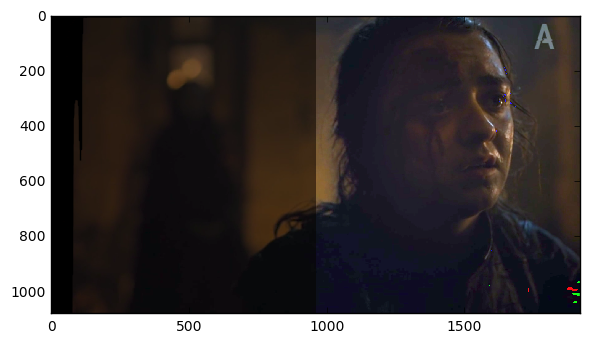

In [13]:
img1 = Linear1(aria, 2)
#imshow(img1)
#plt.show()
spliced_img1 = splice2(aria, img1)
imshow(spliced_img1)
imsave('2.2.1_spliced_img1.png', spliced_img1)
plt.show()

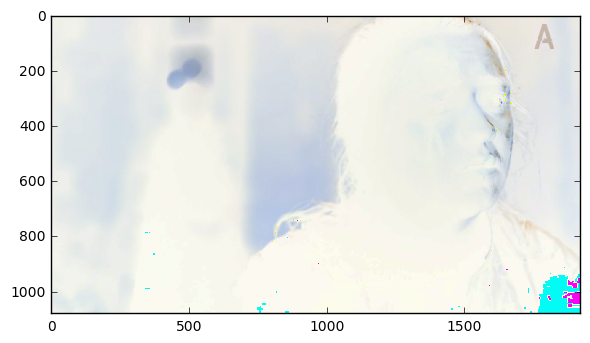

In [14]:
diffmap_area_img1 = np.abs(aria - img1)
imshow(diffmap_area_img1)
imsave('diffmap_area_img1.jpg', diffmap_area_img1)
plt.show()

In [15]:
msi(make_u(aria), make_u(img1))

5.440821436724101

In [16]:
entropy2(make_u(aria), make_u(img1))

-1758.1588635192118 -1777.1558057516845


18.996942232472747

In [17]:
entropy4(make_u(aria), make_u(img1))

-3.776232409129247 -4.573174112003523


0.7969417028742756

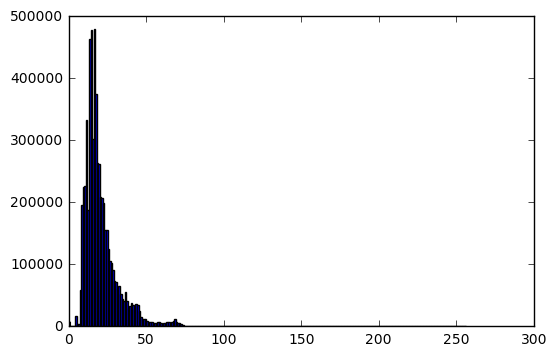

In [19]:
values, bin_edges, patches = hist(aria.ravel(), bins= range(257))
plt.show()

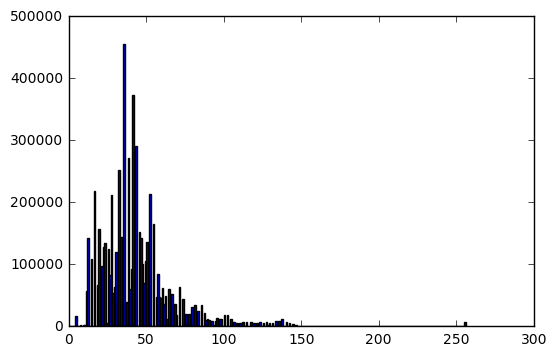

In [20]:
values, bin_edges, patches = hist(img1.ravel(), bins= range(257))
plt.show()